# Everything checks out except for the 0s that should be nan. I think these 0s come when a site does not have a variable (happens alot with water potential and reduction potential), so the code seems to just add a column of 0s for those sites

# Also, if a site has a variable (such as soil moisture) at one depth but CO2 at 2 depths, then we will get 0s instead of nan for the depth where we have CO2 but not soil moisture.

## Some 0s should be nan for Calhoun
## BGZOB water potential and reduction potential should be nan at the beginning, not 0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit == 'R1C1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()
            
        if pit == 'R1H1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
    
        if pit == 'R1P1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'LRMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'TMMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'NPMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'SPVF':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
          
      
        if pit == 'BGZOB1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue
                        if np.all(df[col])==0:
                            df[col]=np.nan
                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
        if pit == 'BGZOB3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'Green2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC5':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC6':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()

In [2]:
if np.all(cur_data[:,7]==0)==True:
    print ('True')
else:
    print ('False')
#np.all(cur_data[:,1])==0   
np.all(cur_data[:,6])

False


True

In [3]:
i=2
for site in all_pits.keys():
    for pit in all_pits[site]:
        print (pit)
print (unique_depths)
matches
col

R1C1
R1C2
R1H1
R1P1
BGZOB1
BGZOB2
BGZOB3
BGZOB4
Green1
Green2
Green3
MC1
MC2
MC3
MC4
MC5
MC6
SFPit1
LRMS
NPMS
SPMS
SPVF
TMMS
['30']


'O2_30cm.percent.0-100'

In [4]:
#df1=pd.DataFrame(data, index=['A'])
data
#cur_data

{'R1C1': array([[1.31800000e+04,            nan, 3.58000000e-01, ...,
         1.94093357e+01,            nan,            nan],
        [1.35700000e+04, 0.00000000e+00, 3.58000000e-01, ...,
         1.94130193e+01,            nan,            nan],
        [1.38300000e+04, 0.00000000e+00, 3.58000000e-01, ...,
         1.94173727e+01,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]),
 'R1H1': array([[1.31500000e+04,            nan, 3.16000000e-01, ...,
         2.01908655e+01,            nan,            nan],
        [1.57350000e+04,            nan, 3.16000000e-01, ...,
         1.99086872e+01,            nan,            nan],
        [

In [5]:
merged=np.vstack(( data['R1C1'], data['R1H1'], data['R1P1'],  data['TMMS'], data['LRMS'], data['NPMS'], data['SPVF'], data['BGZOB1'], data['BGZOB2'], data['BGZOB3'], data['BGZOB4'], data['Green1'], data['Green2'], data['Green3'], data['MC1'], data['MC2'], data['MC3'], data['MC4'], data['MC5'], data['MC6']))
#
df=pd.DataFrame(data=merged, columns=['CO2', 'Precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential'])

In [6]:
df.dropna(subset=['CO2'], inplace=True)
df

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,WaterPotential,ReductionPotential
0,13180.00000,NaN,0.358,0.044,16.65000,19.409336,NaN,NaN
1,13570.00000,0.0,0.358,0.044,16.70500,19.413019,NaN,NaN
2,13830.00000,0.0,0.358,0.044,16.77000,19.417373,NaN,NaN
3,14100.00000,0.0,0.358,0.044,16.83500,19.421726,NaN,NaN
4,14315.00000,0.0,0.358,0.044,16.89000,19.425410,NaN,NaN
...,...,...,...,...,...,...,...,...
2691424,908.66450,NaN,NaN,NaN,1.95875,12.620250,NaN,412.000
2691425,899.26600,NaN,NaN,NaN,1.96000,12.633500,NaN,412.125
2691426,906.60550,NaN,NaN,NaN,1.95975,12.656000,NaN,412.100
2691427,907.19025,NaN,NaN,NaN,1.95500,12.660750,NaN,412.725


In the above, we'll need to make sure all the data is in the same units, across all sites

Basically, the goal is to build up a numpy array where each row is an observation (an individual site/depth/time; e.g., Calhoun R1C1 on January 1st at 12:15 pm) and each column is a parameter (e.g., CO2, Soil moisture, O2, etc). We'll have lots of NaN values, and that's fine for now.

What I would recommend doing is building up one site/pit at a time, then combining arrays later on. For example, the R1C1 array should look like:

|     |CO2|precip|SoilMoisture|BulkEC|Temp|O2|
|---|---|---|---|---|---|---|
|12/12/20 12:15 pm @ 25 cm | 5000 ppm | 0 | 0.24 | NaN | 4.37 | 19.1 |
|12/12/20 12:30 pm @ 25 cm | 5169 ppm | 0 | 0.26 | NaN | 4.45 | 19.2 |
|12/12/20 12:45 pm @ 25 cm | 5120 ppm | 0 | 0.29 | NaN | 4.42 | 19.1 |
|12/12/20 01:00 pm @ 25 cm | 5148 ppm | 0 | 0.26 | NaN | 4.49 | 19.2 |
| ... | ... | ... | ... | ... | ... | ... |
|07/04/18 09:15 am @ 150 cm | 6952 ppm | 0.01 | 0.39 | NaN | 4.3 | 19.1 |
| ... | ... | ... | ... | ... | ... | ... |
| etc | etc | etc | etc | etc | etc | etc |

Except without the columns or index labels. You could also set it up as a pandas dataframe (ie, with column and index labels) then extract the values later on. Whichever is easier.

In [7]:
final_array=df.to_numpy()
output=final_array.copy()
outfile = '../../merged_processed_data/MergeProcessedData.csv'
#output.to_csv(outfile, na_rep=-99999, index_label='record', float_format='%.3f')
np.savetxt(outfile, output, fmt='%.4f', delimiter=",")


In [8]:
output

array([[1.31800000e+04,            nan, 3.58000000e-01, ...,
        1.94093357e+01,            nan,            nan],
       [1.35700000e+04, 0.00000000e+00, 3.58000000e-01, ...,
        1.94130193e+01,            nan,            nan],
       [1.38300000e+04, 0.00000000e+00, 3.58000000e-01, ...,
        1.94173727e+01,            nan,            nan],
       ...,
       [9.06605500e+02,            nan,            nan, ...,
        1.26560000e+01,            nan, 4.12100000e+02],
       [9.07190250e+02,            nan,            nan, ...,
        1.26607500e+01,            nan, 4.12725000e+02],
       [9.15450000e+02,            nan,            nan, ...,
        1.26615000e+01,            nan, 4.12725000e+02]])

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [10]:
df_st =  StandardScaler().fit_transform(df) 

In [11]:
df_st1=pd.DataFrame(data=df_st)
df_med = df_st1.fillna(df_st1.median())
pca = PCA(.95)
pca.fit(df_med)

PCA(n_components=0.95)

In [12]:
pca.explained_variance_ratio_

array([0.24474404, 0.21115074, 0.1621276 , 0.10247044, 0.08855429,
       0.07734082, 0.07000431])

In [13]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
CO2,-0.656286,0.273971,0.201966,0.543073,-0.294712,0.062877,0.257554
Precip,-0.131133,0.301805,-0.942268,0.006276,-0.016745,-0.020417,0.055540
SoilMoisture,0.066591,0.454054,0.102567,0.265358,0.171619,-0.359661,-0.702931
BulkEC,0.067525,0.270018,0.082912,0.176662,0.845981,0.135524,0.386619
Temp,-0.693477,0.020245,0.080532,-0.621170,0.271658,0.000129,-0.224548
O2,-0.248289,-0.732329,-0.206048,0.414955,0.302008,-0.267270,-0.157208
WaterPotential,0.019948,0.110580,0.021933,0.105890,-0.008671,-0.121251,-0.148455
ReductionPotential,-0.011990,-0.076395,-0.067262,0.184812,0.051438,0.872795,-0.435683


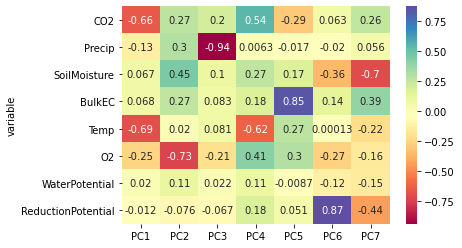

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [15]:
pca_scores = PCA().fit_transform(df_med)

In [18]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [19]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))